# Project Master DS
Malware binary classification

Pietro Marincola

https://ieee-dataport.org/open-access/malware-analysis-datasets-raw-pe-image

In [33]:
#Libraries

import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# Supervised learning models with sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold,RepeatedStratifiedKFold,RandomizedSearchCV, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve,cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score, recall_score, classification_report
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RepeatedEditedNearestNeighbours,RandomUnderSampler
from imblearn.pipeline import make_pipeline as mp

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%matplotlib inline

# Dataset
- hash feature = malware id
- pixel features= 1024 because of conversion 32 x 32 greyscale image
- flattened to a 1024 bytes vector
- label feature = malware

Column name: malware
Description: Class
Type: 0 (Goodware) or 1 (Malware)

In [34]:
orig_visual_malware_dataset = pd.read_csv('./raw_pe_images.csv')
orig_visual_malware_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51959 entries, 0 to 51958
Columns: 1026 entries, hash to malware
dtypes: int64(1025), object(1)
memory usage: 406.7+ MB


In [35]:
orig_visual_malware_dataset.head(3)

,hash,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,...,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023,malware
0,b324140e1fb35dc6b694879ba1f2be45,15,15,239,15,223,36,102,243,102,...,31,242,245,169,212,17,255,160,122,1
1,1d32b1326a524b163eb74af645cd34d5,234,196,8,20,182,56,27,223,144,...,189,228,156,54,189,82,177,125,193,1
2,e44fea4913fc9fd91b8b07c4670aeac4,196,255,5,97,35,112,219,189,217,...,254,189,227,255,192,231,253,196,233,1


## Dataset manipulation

In [36]:
#create label dataset
visual_malware_label = orig_visual_malware_dataset['malware']
#remove unecessary columns
visual_malware_dataset = orig_visual_malware_dataset.drop(['hash','malware'], axis=1)
visual_malware_dataset.head(2)

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,pix_1014,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023
0,15,15,239,15,223,36,102,243,102,102,...,255,31,242,245,169,212,17,255,160,122
1,234,196,8,20,182,56,27,223,144,255,...,213,189,228,156,54,189,82,177,125,193


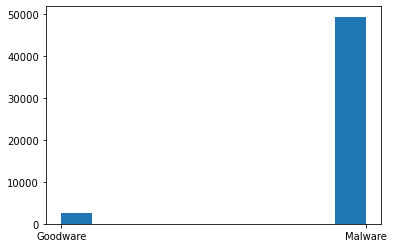

In [37]:
x = orig_visual_malware_dataset.malware
plt.xticks([0,1],['Goodware','Malware'])
plt.hist(x)
plt.show()

Stratification: not balance between classes

inbalance classes - use imblearn

### General

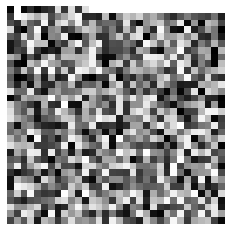

Malware


In [38]:
#Malware image sample
sw_pos = 8
sample_malware = visual_malware_dataset.iloc[sw_pos].to_numpy()
sample_malware_img = sample_malware.reshape(32,32)

plt.imshow(sample_malware_img,cmap="binary")
plt.axis("off")
plt.show()
if visual_malware_label.iloc[sw_pos] == 1:
    print("Malware")
else:
    print("Goodware")

### Under & Over Sampler
stratify: split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(visual_malware_dataset, visual_malware_label,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    shuffle= True,
                                                    stratify=visual_malware_label)
print('dataset label shape original %s' % Counter(y_train))
#Under
rus = RandomUnderSampler(random_state=0, replacement=True)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape under %s' % Counter(y_train_under))
#Over
ros = RandomOverSampler(random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape over %s' % Counter(y_train_over))

dataset label shape original Counter({1: 34563, 0: 1808})
Resampled dataset shape under Counter({0: 1808, 1: 1808})
Resampled dataset shape over Counter({1: 34563, 0: 34563})


In [18]:
#simply scaling pixel values to the range 0-1 to centering and even standardizing the values
X_train_over = X_train_over/255
X_train_under = X_train_under/255
X_test = X_test/255

In [19]:
X_train_under.head(5)

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,pix_1014,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023
0,0.000000,0.250980,0.458824,0.721569,0.031373,0.513725,0.000000,0.407843,0.501961,0.909804,...,0.749020,0.188235,0.639216,0.650980,0.949020,0.254902,0.898039,0.023529,0.705882,0.113725
1,0.000000,0.000000,0.454902,0.000000,0.000000,0.000000,0.000000,0.000000,0.447059,0.000000,...,0.560784,0.847059,0.466667,0.525490,0.003922,0.188235,0.282353,0.192157,0.282353,0.062745
2,0.729412,0.466667,0.117647,0.466667,0.607843,0.466667,0.921569,0.466667,0.886275,0.635294,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.192157,0.000000,0.411765,0.447059,0.411765,0.298039,0.423529,0.341176,0.447059,0.396078,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.784314,0.023529,0.513725,0.819608,0.423529,0.996078,0.270588,0.298039,0.305882,0.007843,...,0.427451,0.396078,0.329412,0.317647,1.000000,1.000000,0.419608,0.921569,0.341176,0.305882


In [21]:
X_train_under.shape

(3616, 1024)

# Classification

## Perceptron
Use cross-validation,

use GridSearch,

Confusion Matrix, 

Recall - Best for our case because I want to reduce False Negative (and accept False positive)


In [22]:
pct = Perceptron()
# define model evaluation method
#---------------------------------- Posso considerare cv come un hyperparametro da inserire in Grid Search ?? ------------------
#cv = StratifiedKFold(n_splits=10)
"""""
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
# define grid
grid = dict()
#alpha Constant that multiplies the regularization term if regularization is used.
grid['alpha'] = [0.0001, 0.01, 0.1]
#The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit method
grid['max_iter'] = [1000]
# define search
search = GridSearchCV(pct, grid, scoring='recall', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean recall: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
print("------------------------------------")
"""""
#cv = StratifiedKFold(n_splits=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
# define grid
grid = dict()
#alpha Constant that multiplies the regularization term if regularization is used.
grid['alpha'] = [0.0001, 0.01, 0.1, 1.0]
#The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit method
grid['max_iter'] = [1000, 10000]
# define search
search = GridSearchCV(pct, grid, scoring='recall', cv=cv, n_jobs=-1)
results_under = search.fit(X_train_under, y_train_under)
print('Mean recall Under Sampled: %.3f' % results_under.best_score_)
print('Config: %s' % results_under.best_params_)
print("------------------------------------")

#cv = StratifiedKFold(n_splits=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
# define grid
grid = dict()
#alpha Constant that multiplies the regularization term if regularization is used.
grid['alpha'] = [0.0001, 0.01, 0.1]
#The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit method
grid['max_iter'] = [1000]
# define search
search = GridSearchCV(pct, grid, scoring='recall', cv=cv, n_jobs=-1)
results_over = search.fit(X_train_over, y_train_over)
print('Mean recall Over Sampled: %.3f' % results_over.best_score_)
print('Config: %s' % results_over.best_params_)


Mean recall Under Sampled: 0.711
Config: {'alpha': 0.0001, 'max_iter': 1000}
------------------------------------
Mean recall Over Sampled: 0.730
Config: {'alpha': 0.0001, 'max_iter': 1000}


Text(0.5, 1.0, 'Perceptron')

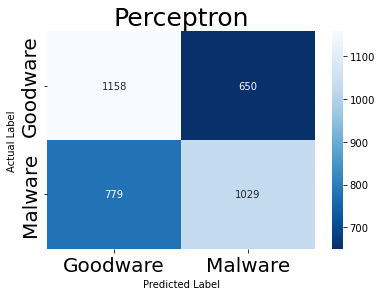

In [23]:
pct = Perceptron()
y_train_pct_predicted_under = cross_val_predict(pct, X_train_under, y_train_under, cv = 10)
sns.heatmap(confusion_matrix(y_train_under,y_train_pct_predicted_under),annot=True,fmt="g",cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.yticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.title("Perceptron", size = 25)


## Classification with Linear Classifier
use K-fold with stratified shuffle

- SGD
- Logistic Regression

In [24]:
sgd_clf = SGDClassifier(random_state=42)
# define model evaluation method
#---------------------------------- Posso considerare cv come un hyperparametro da inserire in Grid Search ?? ------------------
#cv = StratifiedKFold(n_splits=10)
"""""
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['alpha'] = [0.0001, 0.001]
grid['max_iter'] = [1000, 100000]
#grid['tol'] = [0.001, 0.01, 0.1]
# define search
search = GridSearchCV(sgd_clf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
print("------------------------------------")
"""
#cv = StratifiedKFold(n_splits=10)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['alpha'] = [0.0001, 0.001]
grid['max_iter'] = [1000, 100000]
#grid['tol'] = [0.001, 0.01, 0.1]
# define search
search = GridSearchCV(sgd_clf, grid, scoring='recall', cv=cv, n_jobs=-1)
results_under = search.fit(X_train_under, y_train_under)
print('Mean recall Under Sampled: %.3f' % results_under.best_score_)
print('Config: %s' % results_under.best_params_)
print("------------------------------------")
"""
#cv = StratifiedKFold(n_splits=10)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['alpha'] = [0.0001, 0.001]
grid['max_iter'] = [1000, 100000]
#grid['tol'] = [0.001, 0.01, 0.1]
# define search
search = GridSearchCV(sgd_clf, grid, scoring='recall', cv=cv, n_jobs=-1)
results_over = search.fit(X_train_over, y_train_over)
print('Mean recall Over Sampled: %.3f' % results_over.best_score_)
print('Config: %s' % results_over.best_params_)
"""

Mean recall Under Sampled: 0.653
Config: {'alpha': 0.0001, 'max_iter': 1000}
------------------------------------


"\n#cv = StratifiedKFold(n_splits=10)\ncv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)\n# define grid\ngrid = dict()\ngrid['alpha'] = [0.0001, 0.001]\ngrid['max_iter'] = [1000, 100000]\n#grid['tol'] = [0.001, 0.01, 0.1]\n# define search\nsearch = GridSearchCV(sgd_clf, grid, scoring='recall', cv=cv, n_jobs=-1)\nresults_over = search.fit(X_train_over, y_train_over)\nprint('Mean recall Over Sampled: %.3f' % results_over.best_score_)\nprint('Config: %s' % results_over.best_params_)\n"

Text(0.5, 1.0, 'Support Gradient')

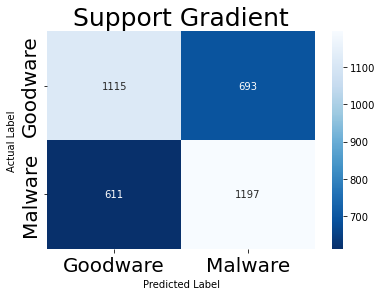

In [25]:
y_train_sgd_predicted_under = cross_val_predict(sgd_clf, X_train_under, y_train_under, cv = 10)
sns.heatmap(confusion_matrix(y_train_under,y_train_sgd_predicted_under),annot=True,fmt="g",cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.yticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.title("Support Gradient", size = 25)

### Logistic Regression

In [26]:
logreg = LogisticRegression(random_state=42)
# define model evaluation method
#---------------------------------- Posso considerare cv come un hyperparametro da inserire in Grid Search ?? ------------------
#cv = StratifiedKFold(n_splits=10)
"""""
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['C'] = [100, 200]
grid['solver'] =['lbfgs', 'liblinear']
grid['max_iter'] = [1000]

#grid['tol'] = [0.001, 0.01, 0.1]
# define search
search = GridSearchCV(logreg, grid, scoring='recall', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean recall: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
print("------------------------------------")
"""
#cv = StratifiedKFold(n_splits=10)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['C'] = [100, 200, 500, 1000]
grid['solver'] =['lbfgs', 'liblinear']
grid['max_iter'] = [10000]
# define search
search = GridSearchCV(logreg, grid, scoring='recall', cv=cv, n_jobs=-1)
results_under = search.fit(X_train_under, y_train_under)
print('Mean recall Under Sampled: %.3f' % results_under.best_score_)
print('Config: %s' % results_under.best_params_)
print("------------------------------------")

""""
#cv = StratifiedKFold(n_splits=10)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['C'] = [100, 200]
grid['solver'] =['lbfgs', 'liblinear']
grid['max_iter'] = [10000]
# define search
search = GridSearchCV(logreg, grid, scoring='recall', cv=cv, n_jobs=-1)
results_over = search.fit(X_train_over, y_train_over)
print('Mean recall Over Sampled: %.3f' % results_over.best_score_)
print('Config: %s' % results_over.best_params_)
"""

Mean recall Under Sampled: 0.675
Config: {'C': 200, 'max_iter': 10000, 'solver': 'lbfgs'}
------------------------------------


'""\n#cv = StratifiedKFold(n_splits=10)\ncv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)\n# define grid\ngrid = dict()\ngrid[\'C\'] = [100, 200]\ngrid[\'solver\'] =[\'lbfgs\', \'liblinear\']\ngrid[\'max_iter\'] = [10000]\n# define search\nsearch = GridSearchCV(logreg, grid, scoring=\'recall\', cv=cv, n_jobs=-1)\nresults_over = search.fit(X_train_over, y_train_over)\nprint(\'Mean recall Over Sampled: %.3f\' % results_over.best_score_)\nprint(\'Config: %s\' % results_over.best_params_)\n'

/Users/pmarincola/opt/anaconda3/envs/dse_ml_project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pmarincola/opt/anaconda3/envs/dse_ml_project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Text(0.5, 1.0, 'Logistic Regression')

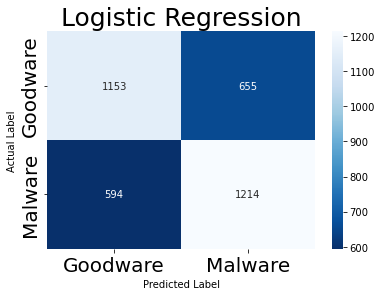

In [27]:
y_train_logreg_predicted_under = cross_val_predict(logreg, X_train_under, y_train_under, cv = 10)
sns.heatmap(confusion_matrix(y_train_under,y_train_logreg_predicted_under),annot=True,fmt="g",cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.yticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.title("Logistic Regression", size = 25)


General consideration about Image recognition: problem with Linear classifier such as SGD 

# Metrics (Test for ROC Curve)

Recall - Best for our case because I want to reduce False Negative (and accept False positive)

Learning curve

Precision/Recall curve

In [ ]:
#SGD learning curve
y_scores = cross_val_predict(sgd_clf, X_train_under,y_train_under, cv=3,method="decision_function")
precisions, recalls, tresholds = precision_recall_curve(y_train_under,y_scores)
fig_sgd = plt.figure(figsize=(13,7))
ax = fig_sgd.add_subplot()
ax.plot(tresholds, precisions[:-1], 'r', label = 'precision')
ax.plot(tresholds, recalls[:-1], 'b', label = 'recall')
ax.title.set_text('SGD Learning curve')
ax.legend(fontsize=20)

In [ ]:
fig_sgd = plt.figure(figsize=(13,7))
ax = fig_sgd.add_subplot()
ax.plot(recalls[:-1], precisions[:-1], 'r', label = 'precision', lw = 7)
ax.title.set_text('SGD Precision vs Recall')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

In [ ]:
#fpr, tpr, tresholds = roc_curve(y_train_malw, y_scores)
fpr, tpr, tresholds = roc_curve(y_train_under, y_scores)

In [ ]:
def plot_roc_curve(fpr,tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0,1],[0,1], "k--")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(fontsize=20)
    plt.grid()
plot_roc_curve(fpr, tpr)
plt.show()


Roc curve should be preferred than precision /recall curve because we care more about false negative than false positives

In [ ]:
#roc_auc_score(y_train_malw, y_scores)
roc_auc_score(y_train_under, y_scores)

# Ensamble classify method

In [8]:
def visualize_ensemble_performance(ax, X, y, scores, scoring):
    data_score = []
    labels = []
    for clf in scores['estimator'][0].estimators_:
        scores_clf = cross_validate(clf, X, y,
                        cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42),
                        return_train_score= True,
                        scoring = scoring,
                        n_jobs=-1)
        data_score.extend([scores_clf[t+s] for s in scoring for t in ['train_','test_']])
        labels.extend([clf.__class__.__name__+'_'+t+s for s in scoring for t in ['train_','test_']])
    data_score.extend([scores[t+s] for s in scoring for t in ['train_','test_']])
    labels.extend(['Voting_'+t+s for s in scoring for t in ['train_','test_']])
    sns.boxplot(ax = ax,
                data = data_score,
                whis = [5, 95],
                palette = "vlag",
                orient = 'h'
               )
    ax.set(yticklabels=labels)

In [32]:
logreg = LogisticRegression(C=500,max_iter=10000, solver='liblinear',random_state=42)
sgd_clf = SGDClassifier(alpha=0.01,max_iter=1000, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('log_reg', logreg), ('sgd', sgd_clf)],
    voting='hard')

In [33]:
scores = cross_validate(voting_clf, X_train_under, y_train_under,
                        cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42),
                        return_estimator = True,
                        return_train_score= True,
                        scoring = ['recall'],
                        n_jobs=-1)

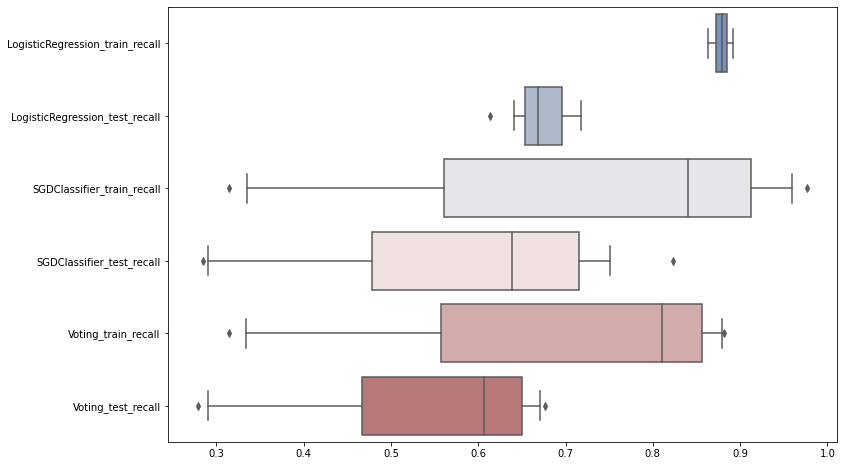

In [34]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
visualize_ensemble_performance(ax, X_train_under, y_train_under, scores, ['recall'])

better with additional cls (like randomForest)

# Random Forest Classifier 

instead of use DecisiontreeClassifier with bagging it is preferred to use RandomForest

In [28]:
forest_clf = RandomForestClassifier(random_state=42)
#y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_malw, cv= 3, method="predict_proba")
y_probas_forest = cross_val_predict(forest_clf, X_train_under,y_train_under, cv= 3, method="predict_proba")

In [29]:
y_scores_forest = y_probas_forest[:, 1]
#fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train_malw, y_scores_forest)
fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train_under, y_scores_forest)

Text(0.5, 1.0, 'Random Forest')

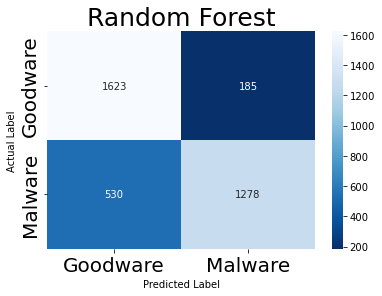

In [30]:
y_train_rf_predicted_under = cross_val_predict(forest_clf, X_train_under, y_train_under, cv = 10)
sns.heatmap(confusion_matrix(y_train_under,y_train_rf_predicted_under),annot=True,fmt="g",cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.yticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.title("Random Forest", size = 25)

In [ ]:
#roc_auc_score(y_train_under,y_scores_forest)

In [31]:
knn = KNeighborsClassifier(n_neighbors=7)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['n_neighbors'] = [7,20]
grid['metric'] =['minkowski']
grid['p'] = [2]
# define search
search = GridSearchCV(knn, grid, scoring='recall', cv=cv, n_jobs=-1)
results_under = search.fit(X_train_under, y_train_under)
print('Mean recall Under Sampled: %.3f' % results_under.best_score_)
print('Config: %s' % results_under.best_params_)
print("------------------------------------")

Mean recall Under Sampled: 0.875
Config: {'metric': 'minkowski', 'n_neighbors': 7, 'p': 2}
------------------------------------


Text(0.5, 1.0, 'KNeighbors')

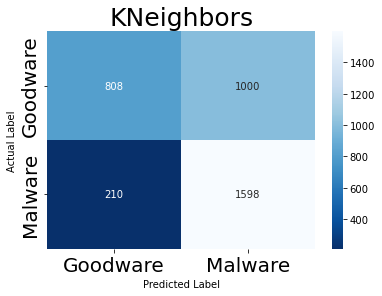

In [32]:
y_train_kn_predicted_under = cross_val_predict(knn, X_train_under, y_train_under, cv = 10)
sns.heatmap(confusion_matrix(y_train_under,y_train_kn_predicted_under),annot=True,fmt="g",cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.yticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.title("KNeighbors", size = 25)

In [42]:
#KNN using original X_train and y_train (w/o under over sampling)
knn_complete = KNeighborsClassifier(n_neighbors=7)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)
# define grid
grid = dict()
grid['n_neighbors'] = [7,20]
grid['metric'] =['minkowski']
grid['p'] = [2]
# define search
search = GridSearchCV(knn_complete, grid, scoring='recall', cv=cv, n_jobs=-1)
results = search.fit(X_train, y_train)
print('Mean recall: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
print("------------------------------------")

Mean recall: 1.000
Config: {'metric': 'minkowski', 'n_neighbors': 7, 'p': 2}
------------------------------------


Text(0.5, 1.0, 'KNeighbors')

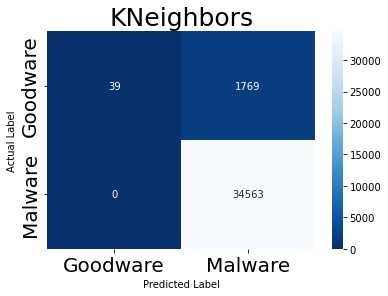

In [43]:
y_train_kn_predicted = cross_val_predict(knn_complete, X_train, y_train, cv = 10)
sns.heatmap(confusion_matrix(y_train,y_train_kn_predicted),annot=True,fmt="g",cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.yticks([0.50,1.50],['Goodware','Malware'],fontsize=20)
plt.title("KNeighbors", size = 25)

### good result for False negative but high for false positive

In [44]:
knn_complete.fit(X_train,y_train)
y_pred_knn_complete = knn_complete.predict(X_test)
y_pred_knn_complete

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
accuracy_score(y_pred_knn_complete,y_test)
print(classification_report(y_pred_knn_complete,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97     15588

    accuracy                           0.95     15588
   macro avg       0.50      0.48      0.49     15588
weighted avg       1.00      0.95      0.97     15588



/Users/pmarincola/opt/anaconda3/envs/dse_ml_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pmarincola/opt/anaconda3/envs/dse_ml_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pmarincola/opt/anaconda3/envs/dse_ml_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Conclusion: 
